In [1]:
import sys
import os
import logging

import numpy as np
import torch
from tqdm import tqdm
import pytorch_lightning as pl
import matplotlib.pyplot as plt

sys.path.append('../')
from HDN.models.lvae import LadderVAE
from utils.dataloaders import Dataset

plt.style.use("dark_background")
plt.rc("figure", figsize=[20, 5])
logger = logging.getLogger('pytorch_lightning')
logger.setLevel(logging.WARNING)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load trained denoiser

In [3]:
denoiser_location = '../dn_checkpoint'
vae = LadderVAE.load_from_checkpoint(os.path.join(denoiser_location, 'final_params.ckpt')).to(device).eval()

/home/ben/miniforge3/envs/dnm/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'noise_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['noise_model'])`.


Load noisy measurements and corresponding ground truth

In [4]:
particle_location = "./sample_data/Particle.npy"
particle = np.load(particle_location)
at_particle = particle[:, 1] # In our data, the attenuated scattering is the channel is the second
gt_particle = particle[:, 2] # and the corresponding ground truth is the third

# We reshape it to fit pytorch's conventional input shape
at_particle = at_particle.reshape((4000, 1, 1000))
gt_particle = gt_particle.reshape((4000, 1, 1000))

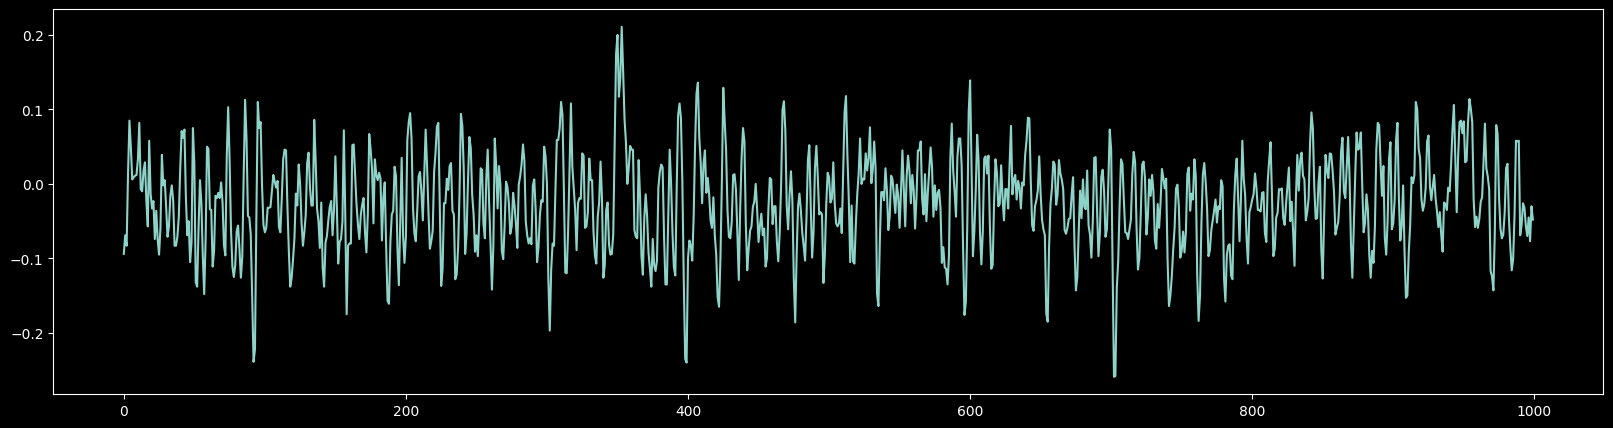

In [5]:
plt.plot(at_particle[5].squeeze(), label='Attenuated Scattering')

In [6]:
def align_gt(at, gt, lower=0.2, upper=30):
    """
    Shifts the ground truth to have the same baseline as the attenuated
    and scales it so that the average height of its peaks is the same as
    that of the attenuated channel.

    Parameters
    ----------
    at : np.ndarray
        The attenuated channel
    gt : np.ndarray
        The ground truth channel
    lower : float
        The lower bound of the peak height to consider
    upper : float
        The upper bound of the peak height to consider
    """

    # Shift both attenuated and ground truth data so that their baselines are both at zero
    zeroed_at = at - np.median(at)
    zeroed_gt = gt - np.median(gt)

    # Calculates the scale that will give the ground truth data the same average peak height as the
    # attenuated data.
    scale = np.mean(zeroed_gt) / np.mean(zeroed_at)

    # The zeroed ground truth is scaled by this factor and its baseline is shifted to be
    # the same as that of the attenuated data.
    aligned_gt = (zeroed_gt / scale) + np.median(at)

    # This will be used to identify windows containing peaks
    maximums = np.max(gt, axis=2).squeeze()

    # Index the windows with a peak in the corresponding ground truth window
    at_peaks = at[(maximums > lower) & (maximums < upper)]
    aligned_gt_peaks = aligned_gt[(maximums > lower) & (maximums < upper)]

    return at_peaks, aligned_gt_peaks

We split both timeseries of attenuated and ground truth data into windows of length 1000, and now we will select only those windows that contain a peak. We consider a window to contain a peak if the maximum value in the ground truth is greater than 0.2.

In [7]:
at_peaks, gt_peaks = align_gt(at_particle, gt_particle, lower=0.2, upper=30)

These windows are then loaded into a Pytorch dataloader.
If an out-of-memory error is encountered, reduce the `batch_size`.

In [8]:
batch_size = 100
predict_set = Dataset(at_peaks)
predict_loader = torch.utils.data.DataLoader(
    predict_set, batch_size=batch_size, shuffle=False, pin_memory=True
)

Evaluate

By default, we denoise each image 100 times and average the results. For an MMSE estimate, set `average` to `"mean"`, for an MAE estimate, set `average` to `"median"`.

In [9]:
n_samples = 100
average = "median"

trainer = pl.Trainer(
    default_root_dir=denoiser_location,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    enable_progress_bar=False,
)

samples = []
for _ in tqdm(range(n_samples)):
    out = trainer.predict(vae, predict_loader)
    out = torch.cat(out, dim=0)
    samples.append(out)

samples = torch.stack(samples, dim=0)
samples = torch.moveaxis(samples, 1, 0)

if average == "mean":
    avg = torch.mean(samples, dim=1)
elif average == "median":
    avg = torch.median(samples, dim=1)[0]

100%|██████████| 100/100 [03:31<00:00,  2.12s/it]


Compare visually to signal

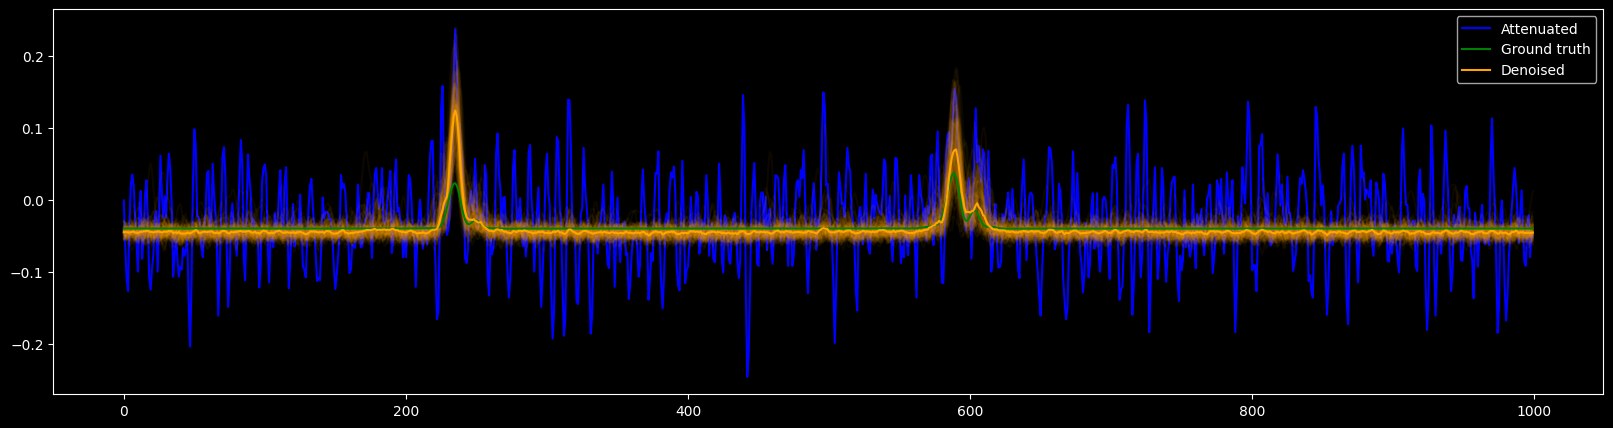

In [10]:
idx = np.random.randint(len(at_peaks))

plt.plot(at_peaks[idx, 0], color="blue", label="Attenuated")
for i in range(n_samples):
    plt.plot(samples[idx, i, 0], color="orange", alpha=0.05)
plt.plot(gt_peaks[idx, 0], color="green", label="Ground truth")
plt.plot(avg[idx, 0], color="orange", label="Denoised")

plt.legend()
plt.show()

Create PSNR function

In [11]:
def PSNR(gt, img, psnrRange):
    '''
    Compute PSNR.
    Parameters
    ----------
    gt: array
        Ground truth image.
    img: array
        Predicted image.
    psnrRange: float
        Range PSNR
    '''
    mse = np.mean((gt - img)**2)
    return 20 * np.log10(psnrRange) - 10 * np.log10(mse)

Compute PSNR

In [12]:
psnrs = []
range_psnr = np.max(gt_peaks) - np.min(gt_peaks)
for i in range(len(avg)):
    psnrs.append(
        PSNR(gt_peaks[i], avg[i, 0].numpy(), psnrRange=range_psnr)
    )
np.mean(psnrs)

21.643233539030195

Save results including raw data peaks

In [13]:
results_directory = '../results'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
np.save(os.path.join(results_directory, average + '.npy'), avg)
np.save(os.path.join(results_directory, 'samples.npy'), samples)
np.save(os.path.join(results_directory, "attenuated.npy"), at_peaks)
np.save(os.path.join(results_directory, "ground_truth.npy"), gt_peaks)